# Multiclass Classification for math questions using OpenAI
For this notebook we will be looking to classify the questions in the subject of Mathematics based on models of OpenAI. 
The categories are divided into two groups:
1. Difficulty levels: Introductory, Intermediate and Olympiad
2. Topics: Geometry, Number Theory, Algebra and Combinatorics
The questions are sourced from https://artofproblemsolving.com/ with Mathpix OCR tool to transform into Latex format, the categories labels are given by the website。
For example, questions which are labelled "Olypiad" and "Number Theory" are captured from https://artofproblemsolving.com/wiki/index.php/Category:Olympiad_Number_Theory_Problems.
The questions are selected randomly to avoid bias. 


We will use three different methods: inspired by https://github.com/openai/openai-cookbook/blob/main/examples/Multiclass_classification_for_questions.ipynb.
1.  **Zero-shot Classification:** using prompt guidance
2.  **Fine-tune Model**
3.  **Text embeddings**


Although there are a few discussions of the latter two methods in the purpose of classification, there are no many Latex-based comparisons have been made. 


The TexGPT https://blog.writefull.com/texgpt-harness-the-power-of-chatgpt-in-overleaf/ shows the potention of GPT understanding Latex codes. 

In [1]:
%load_ext autoreload
%autoreload 
import openai
import pandas as pd
import numpy as np
import json
import os

api_key = ''
openai.api_key = api_key
COMPLETIONS_MODEL = "text-davinci-003"

## Load Dataset
I have uploaded the dataset to https://huggingface.co/datasets/AFFFPupu/Maths_competition_questions/blob/main/AMC_questions.csv

The CSV file has three main features:
1. Difficulty
2. label
3. Question

In [2]:
questions = pd.read_csv('/Users/aofu/Desktop/AMC_questions.csv', encoding= 'unicode_escape')
#To clean the form
questions['Label'] = questions['Label'].str.replace('Combinatorics\n', 'Combinatorics')
questions = questions.rename(columns={'Label': 'Topic'})
questions

,ID,Difficulty,Topic,Question
0,1,Intermediate,Combinatorics,Convex polygons $P_1$ and $P_2$ are drawn in t...
1,2,Intermediate,Combinatorics,Suppose that $n$ people each know exactly one ...
2,3,Intermediate,Combinatorics,"The numbers 1447,1005 and 1231 have something ..."
3,4,Intermediate,Combinatorics,"For $\{1,2,3, \ldots, n\}$ and each of its non..."
4,5,Intermediate,Combinatorics,"For $\{1,2,3, \ldots, n\}$ and each of its non..."
...,...,...,...,...
117,116,Olympiad,Number Theory,Let $k_1<k_2<k_3<\cdots$; be positive integers...
118,117,Olympiad,Number Theory,Let $a>b>c>d$ be positive integers and suppose...
119,118,Olympiad,Number Theory,"Determine the maximum value of $m^2+n^2$, wher..."
120,119,Olympiad,Number Theory,A permutation of the set of positive integers ...


In [3]:
questions['Topic'].value_counts()

Topic
Combinatorics    30
Geometry         30
Algebra          30
Number Theory    30
Name: count, dtype: int64

In [4]:
def request_completion(prompt):
    
    completion_response =   openai.Completion.create(
                            prompt=prompt,
                            temperature=0,
                            max_tokens=5,
                            top_p=1,
                            frequency_penalty=0,
                            presence_penalty=0,
                            model=COMPLETIONS_MODEL
                            )
        
    return completion_response

def classify_question(question,prompt):
    
    prompt = prompt.replace('QUESTION_CONTENT',str(question['Question']))
    
    classification = request_completion(prompt)['choices'][0]['text'].replace('\n','')
    
    return classification

# This function takes your training and validation outputs from the prepare_data function of the Finetuning API, and
# confirms that each have the same number of classes.
# If they do not have the same number of classes the fine-tune will fail and return an error

def check_finetune_classes(train_file,valid_file):

    train_classes = set()
    valid_classes = set()
    with open(train_file, 'r') as json_file:
        json_list = list(json_file)
        print(len(json_list))

    for json_str in json_list:
        result = json.loads(json_str)
        train_classes.add(result['completion'])
        #print(f"result: {result['completion']}")
        #print(isinstance(result, dict))

    with open(valid_file, 'r') as json_file:
        json_list = list(json_file)
        print(len(json_list))

    for json_str in json_list:
        result = json.loads(json_str)
        valid_classes.add(result['completion'])
        #print(f"result: {result['completion']}")
        #print(isinstance(result, dict))
        
    if len(train_classes) == len(valid_classes):
        print('All good')
        
    else:
        print('Classes do not match, please prepare data again')

### Prepare prompts for topics classification

In [5]:
zero_shot_prompt_topic = '''You are an experienced American high school teacher who is very familar with american mathematical contests. 
You are analysing the Latex codes of questions and classifying them into one of four categories based on their corresponding maths topics.
The four categories are Algebra, Number Theory, Geometry and Combinatorics.
If you can't tell what it is, say Could not classify
                      
Question:
                      
QUESTION_CONTENT
                      
The classification is:'''

In [6]:
question = questions.iloc[20]
prompt = zero_shot_prompt_topic.replace('QUESTION_CONTENT',question['Question'])
completion_response = request_completion(prompt)
print(completion_response['choices'][0]['text'])

 Algebra


### Prepare prompts for difficulty classification

In [7]:
zero_shot_prompt_difficulty = '''You are an experienced American high school teacher who is very familar with american mathematical contests. 
You are analysing the Latex codes of questions and classifying them into one of three categories based on their difficulties.
The three categories are "Introductory", "Intermediate", "Olympiad"
Introductory means easy, and Olympiad means quite hard.
If you can't tell what it is, say Could not classify
                      
Question:
                      
QUESTION_CONTENT
                      
The classification is:'''

In [8]:
question = questions.iloc[1]
prompt = zero_shot_prompt_difficulty.replace('QUESTION_CONTENT',question['Question'])
completion_response = request_completion(prompt)
print(completion_response['choices'][0]['text'])

 Olympiad


### Create new columns in the dataframe to show zero-shot results

In [ ]:
#create columns in the question to show the results of zero-shot classification
questions_zeroshot = questions.copy()
questions_zeroshot['Topic_zeroshot'] = ''
questions_zeroshot['Difficulty_zeroshot'] = ''
for i in range(len(questions_zeroshot)):
    question = questions_zeroshot.iloc[i]
    prompt = zero_shot_prompt_topic.replace('QUESTION_CONTENT',str(question['Question']))
    completion_response = request_completion(prompt)
    questions_zeroshot.loc[i,'Topic_zeroshot'] = completion_response['choices'][0]['text']
    
    prompt = zero_shot_prompt_difficulty.replace('QUESTION_CONTENT',str(question['Question']))
    completion_response = request_completion(prompt)
    questions_zeroshot.loc[i,'Difficulty_zeroshot'] = completion_response['choices'][0]['text']

questions_zeroshot['Topic_zeroshot'] = questions_zeroshot['Topic_zeroshot'].str.strip()

In [111]:
questions_zeroshot['Topic_zeroshot'] = questions_zeroshot['Topic_zeroshot'].str.strip()
questions_zeroshot['Difficulty_zeroshot'] = questions_zeroshot['Difficulty_zeroshot'].str.strip()

In [120]:
questions_zeroshot['Difficulty_zeroshot'].value_counts()
# we can see not many introductory questions are classified; they are more likely to be classified as intermediate

Difficulty_zeroshot
Intermediate          70
Olympiad              47
Could not classify     2
Introductory           2
1. Olymp               1
Name: count, dtype: int64

### Evaluating the zero-shot results

In [117]:
questions_zeroshot['correct_topic'] = questions_zeroshot['Topic'] == questions_zeroshot['Topic_zeroshot']
questions_zeroshot['correct_difficulty'] = questions_zeroshot['Difficulty'] == questions_zeroshot['Difficulty_zeroshot']
questions_zeroshot['correct_topic'].value_counts()

correct_topic
True     89
False    33
Name: count, dtype: int64

In [118]:
questions_zeroshot['correct_difficulty'].value_counts()

correct_difficulty
False    66
True     56
Name: count, dtype: int64

## Fine Tune

To prepare our dataset for fine-tuning, we should update the OpenAI library to ensure we're using the latest version that includes the data preparation tool. Use the following command to upgrade the library:

```
pip install --upgrade openai -q
```

By adding the `-q` flag, we can automatically accept all suggestions provided by the data preparation tool, streamlining the process.

With the library updated and the tool in place, we can now utilize it to enhance our dataset by incorporating the suggested improvements. These enhancements will facilitate the subsequent fine-tuning process.

In [133]:
list(set(questions['Topic']))

['Geometry', 'Combinatorics', 'Number Theory', 'Algebra']

In [141]:
questions = questions.dropna()
topic_classes = list(set(questions['Topic']))
topic_classes_df = pd.DataFrame(topic_classes).reset_index()
topic_classes_df.columns = ['Topic_id','Topic']
topic_classes_df, len(topic_classes_df)

(   Topic_id          Topic
 0         0       Geometry
 1         1  Combinatorics
 2         2  Number Theory
 3         3        Algebra,
 4)

In [142]:
difficulty_classes = list(set(questions['Difficulty']))
difficulty_classes_df = pd.DataFrame(difficulty_classes).reset_index()
difficulty_classes_df.columns = ['Difficulty_id','Difficulty']
difficulty_classes_df, len(difficulty_classes_df)

(   Difficulty_id    Difficulty
 0              0  Intermediate
 1              1  Introductory
 2              2      Olympiad,
 3)

In [147]:
df_topic = questions.merge(topic_classes_df, left_on='Topic', right_on='Topic', how='left')
# Adding a leading whitespace onto each completion to help the model
df_topic['Topic_id'] = df_topic.apply(lambda x: ' ' + str(x['Topic_id']), axis=1)
# Adding a common separator onto the end of each prompt so the model knows when a prompt is terminating
df_topic['prompt'] = df_topic.apply(lambda x: x['Question'] + '\n\n###\n\n',axis=1)
df_topic_ft =pd.DataFrame(zip(df_topic['prompt'],df_topic['Topic_id']),columns = ['prompt','completion'])
# We export our randomized DataFrame to a .jsonl file and then execute the prepare_data function to generate our necessary input files.
df_topic_ft.to_json('topic_ft.jsonl', orient='records', lines=True)

df_difficulty = questions.merge(difficulty_classes_df, left_on='Difficulty', right_on='Difficulty', how='left')
# Adding a leading whitespace onto each completion to help the model
df_difficulty['Difficulty_id'] = df_difficulty.apply(lambda x: ' ' + str(x['Difficulty_id']), axis=1)
# Adding a common separator onto the end of each prompt so the model knows when a prompt is terminating
df_difficulty['prompt'] = df_difficulty.apply(lambda x: x['Question'] + '\n\n###\n\n',axis=1)
df_difficulty_ft =pd.DataFrame(zip(df_difficulty['prompt'],df_difficulty['Difficulty_id']),columns = ['prompt','completion'])
# We export our randomized DataFrame to a .jsonl file and then execute the prepare_data function to generate our necessary input files.
df_difficulty_ft.to_json('difficulty_ft.jsonl', orient='records', lines=True)

We are now ready to utilize a data preparation tool that will recommend several enhancements to our dataset prior to fine-tuning. 

Prior to activating this tool, we ensure we have the latest data preparation tool by updating the openai library. 

We also append -q to automatically accept all proposed improvements.

In [148]:
!openai tools fine_tunes.prepare_data -f topic_ft.jsonl -q

Analyzing...

- Your file contains 120 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 2 duplicated prompt-completion sets. These are rows: [4, 29]
- All prompts end with suffix `\n\n###\n\n`

Based on the analysis we will perform the following actions:
- [Recommended] Remove 2 duplicate rows [Y/n]: Y
- [Recommended] Would you like to split into training and validation set? [Y/n]: Y


Your data will be written to a new JSONL file. Proceed [Y/n]: Y

Wrote modified files to `topic_ft_prepared_train.jsonl` and `topic_ft_prepared_valid.jsonl`
Feel free to take a look!

Now use that file when fine-tuning:
> openai api fine_tunes.create -t "topic_ft_prepared_train.jsonl" -v "topic_ft_prepared_

This function verifies that your categories are present in both prepared files. 

If they're not, the process of creating the fine-tuned model will be unsuccessful.

In [151]:
check_finetune_classes('topic_ft_prepared_train.jsonl','topic_ft_prepared_valid.jsonl')

94
24
All good


In [149]:
!openai tools fine_tunes.prepare_data -f difficulty_ft.jsonl -q

Analyzing...

- Your file contains 120 prompt-completion pairs
- Based on your data it seems like you're trying to fine-tune a model for classification
- For classification, we recommend you try one of the faster and cheaper models, such as `ada`
- For classification, you can estimate the expected model performance by keeping a held out dataset, which is not used for training
- There are 2 duplicated prompt-completion sets. These are rows: [4, 29]
- All prompts end with suffix `\n\n###\n\n`

Based on the analysis we will perform the following actions:
- [Recommended] Remove 2 duplicate rows [Y/n]: Y
- [Recommended] Would you like to split into training and validation set? [Y/n]: Y


Your data will be written to a new JSONL file. Proceed [Y/n]: Y

Wrote modified files to `difficulty_ft_prepared_train.jsonl` and `difficulty_ft_prepared_valid.jsonl`
Feel free to take a look!

Now use that file when fine-tuning:
> openai api fine_tunes.create -t "difficulty_ft_prepared_train.jsonl" -v "dif

In [152]:
check_finetune_classes('difficulty_ft_prepared_train.jsonl','difficulty_ft_prepared_valid.jsonl')

94
24
All good


### Create the models

In [153]:
!openai api fine_tunes.create -t "topic_ft_prepared_train.jsonl" -v "topic_ft_prepared_valid.jsonl" --compute_classification_metrics --classification_n_classes 4 -m ada
!openai api fine_tunes.create -t "difficulty_ft_prepared_train.jsonl" -v "difficulty_ft_prepared_valid.jsonl" --compute_classification_metrics --classification_n_classes 3 -m ada

Upload progress: 100%|████████████████████| 29.0k/29.0k [00:00<00:00, 32.9Mit/s]
Uploaded file from topic_ft_prepared_train.jsonl: file-DRYubhWZsg2wLuU85CU5HNOT
Upload progress: 100%|████████████████████| 7.99k/7.99k [00:00<00:00, 11.8Mit/s]
Uploaded file from topic_ft_prepared_valid.jsonl: file-tlK6PlTdjn0rGNgPfpDGlqE8
Created fine-tune: ft-kDhIr2YrNXWbrskRD9FkkH93
Streaming events until fine-tuning is complete...

(Ctrl-C will interrupt the stream, but not cancel the fine-tune)
[2023-06-29 12:33:40] Created fine-tune: ft-kDhIr2YrNXWbrskRD9FkkH93

Stream interrupted (client disconnected).
To resume the stream, run:

  openai api fine_tunes.follow -i ft-kDhIr2YrNXWbrskRD9FkkH93

Upload progress: 100%|████████████████████| 29.0k/29.0k [00:00<00:00, 21.9Mit/s]
Uploaded file from difficulty_ft_prepared_train.jsonl: file-4c8lfemMUXJE241GEMt6nO5V
Upload progress: 100%|████████████████████| 7.99k/7.99k [00:00<00:00, 6.64Mit/s]
Uploaded file from difficulty_ft_prepared_valid.jsonl: file-DZcPx

Once the job finished, you can use openai.FineTune.list() to check the progress and usually it takes 30mins for each model.

**In terminal**

curl https://api.openai.com/v1/files/<file_name>/content \
  -H "Authorization: Bearer <OpenAI_API_KEY>" > results.csv

In [11]:
openai.FineTune.list()
#find the result file id for topic and difficulty
#for me, it is file-nKSEG3Z0BaCCWnuVzTN2nmRd for topics and file-RJMsYeVxPiqOLxnzx05kbXb5 for difficulty

<OpenAIObject list at 0x168d0c090> JSON: {
  "object": "list",
  "data": [
    {
      "object": "fine-tune",
      "id": "ft-3RDYV6SqTMiALu7l4HM4MQw5",
      "hyperparams": {
        "n_epochs": 4,
        "batch_size": null,
        "prompt_loss_weight": 0.01,
        "learning_rate_multiplier": null,
        "classification_positive_class": " baseball",
        "compute_classification_metrics": true
      },
      "organization_id": "org-IIIsIVRM80b5kgxKAOlct3EC",
      "model": "ada",
      "training_files": [
        {
          "object": "file",
          "id": "file-yIF3Sokh4IBlpYxjVsZGYe0P",
          "purpose": "fine-tune",
          "filename": "sport2_prepared_train.jsonl",
          "bytes": 1519036,
          "created_at": 1687951026,
          "status": "deleted",
          "status_details": null
        }
      ],
      "validation_files": [
        {
          "object": "file",
          "id": "file-HRQhmgmLnUP477g9dw3EhNdD",
          "purpose": "fine-tune",
          

In [12]:
results_topic = pd.read_csv('results_topic.csv')
results_topic[results_topic['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/weighted_f1_score
377,378,35618,378,0.015012,1.0,1.0,NaN,NaN,NaN,0.75,0.751832


In [14]:
results_difficulty = pd.read_csv('results_difficulty.csv')
results_difficulty[results_difficulty['classification/accuracy'].notnull()].tail(1)

,step,elapsed_tokens,elapsed_examples,training_loss,training_sequence_accuracy,training_token_accuracy,validation_loss,validation_sequence_accuracy,validation_token_accuracy,classification/accuracy,classification/weighted_f1_score
378,379,35779,379,0.022677,1.0,1.0,NaN,NaN,NaN,0.791667,0.79386


<Axes: >

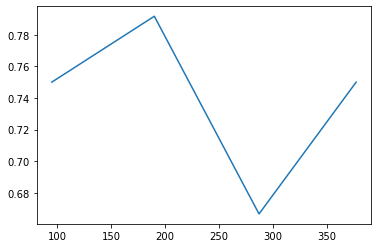

In [15]:
results_topic[results_topic['classification/accuracy'].notnull()]['classification/accuracy'].plot()

<Axes: >

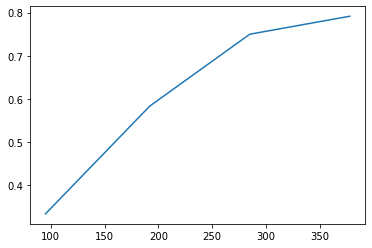

In [16]:
results_difficulty[results_difficulty['classification/accuracy'].notnull()]['classification/accuracy'].plot()

## Classification using Embeddings

I have tried to compare the models performance and chosen second generation "text-embedding-ada-002", babbage model "text-similarity-babbage-001" and code-search "code-search-ada-code-001". 


Please try to check the model availability on https://github.com/MicrosoftDocs/azure-docs/blob/main/articles/cognitive-services/openai/concepts/models.md#embeddings-models.

In [170]:
from transformers import GPT2TokenizerFast
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
questions_embedding = questions.copy()
questions_embedding['n_tokens'] = questions_embedding.Question.apply(lambda x: len(tokenizer.encode(x)))

def get_embedding_ada(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']
def get_embedding_ada_codesearch(text, model="code-search-ada-code-001"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']
def get_embedding_babbage_similarity(text, model="text-similarity-babbage-001"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']
#def get_embedding_babbage_search(text, model="text-search-babbage-docs-001"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']
#def get_embedding_curie(text, model="text-embedding-curie-001"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']
#def get_embedding_davinci(text, model="text-embedding-davinci-001"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

questions_embedding['ada'] = questions_embedding.Question.apply(lambda x: get_embedding_ada(x))
questions_embedding['babbage_similarity'] = questions_embedding.Question.apply(lambda x: get_embedding_babbage_similarity(x))
questions_embedding['ada_codesearch'] = questions_embedding.Question.apply(lambda x: get_embedding_ada_codesearch(x))   
#questions_embedding['babbage_search'] = questions_embedding.Question.apply(lambda x: get_embedding_babbage_search(x))
#questions_embedding['curie'] = questions_embedding.Question.apply(lambda x: get_embedding_curie(x))
#questions_embedding['davinci'] = questions_embedding.Question.apply(lambda x: get_embedding_davinci(x))
#questions_embedding['babbage_similarity'] = questions_embedding.Question.apply(lambda x: get_embedding(x, engine='text-similarity-babbage-001'))
#questions_embedding['ada_similarity'] = questions_embedding.Question.apply(lambda x: get_embedding(x, engine='text-similarity-ada-001'))
#questions_embedding['babbage_search'] = questions_embedding.Question.apply(lambda x: get_embedding(x, engine='text-search-babbage-docs-001'))
#questions_embedding['ada_search'] = questions_embedding.Question.apply(lambda x: get_embedding(x, engine='text-search-ada-docs-001'))

In [172]:
questions_embedding.to_csv('questions_embedding.csv')

In [195]:
questions_embedding.head(20)

,ID,Difficulty,Topic,Question,n_tokens,ada,babbage_similarity,ada_codesearch
0,1,Intermediate,Combinatorics,Convex polygons $P_1$ and $P_2$ are drawn in t...,90,"[0.01974869892001152, -0.016672004014253616, 0...","[0.029648803174495697, 0.02339709736406803, -0...","[0.004396980628371239, -0.03423513472080231, 0..."
1,2,Intermediate,Combinatorics,Suppose that $n$ people each know exactly one ...,85,"[0.00313008320517838, -0.012422923929989338, 0...","[0.004858825355768204, 0.008984063751995564, 0...","[0.003928975202143192, 0.0064662154763937, 0.0..."
2,3,Intermediate,Combinatorics,"The numbers 1447,1005 and 1231 have something ...",39,"[0.012417293153703213, 0.00888371467590332, 0....","[0.0024372031912207603, 0.009992768056690693, ...","[0.00293885194696486, -0.008723926730453968, 0..."
3,4,Intermediate,Combinatorics,"For $\{1,2,3, \ldots, n\}$ and each of its non...",123,"[-0.0029080586973577738, -0.006373782642185688...","[-0.016308356076478958, 0.022673040628433228, ...","[0.0006934572011232376, -0.0012639530468732119..."
4,5,Intermediate,Combinatorics,"For $\{1,2,3, \ldots, n\}$ and each of its non...",123,"[-0.0029080586973577738, -0.006373782642185688...","[-0.016308356076478958, 0.022673040628433228, ...","[0.0006934572011232376, -0.0012639530468732119..."
5,6,Intermediate,Combinatorics,Twenty five of King Arthur's knights are seate...,84,"[0.01058992836624384, -0.014744133688509464, -...","[-0.006555486470460892, 0.0031027747318148613,...","[0.009600513614714146, -0.0034321194980293512,..."
6,7,Intermediate,Combinatorics,What is the largest 2-digit prime factor of th...,34,"[0.007422182708978653, -0.003385892603546381, ...","[-0.01557550486177206, -0.0013615108327940106,...","[-0.02048683539032936, -0.03081326186656952, 0..."
8,8,Intermediate,Combinatorics,"A gardener plants three maple trees, four oaks...",68,"[-0.015599456615746021, -0.03689311072230339, ...","[-0.006298569031059742, 0.031910356134176254, ...","[0.014418322592973709, 0.0071385265327990055, ..."
9,9,Intermediate,Combinatorics,"Let $A, B, C$ and $D$ be the vertices of a reg...",123,"[0.010129581205546856, 0.0013081190409138799, ...","[-0.012420452199876308, 0.03054886683821678, -...","[0.01406455971300602, -0.022264430299401283, 0..."
10,10,Intermediate,Combinatorics,In a tournament each player played exactly one...,126,"[0.0002010460739256814, -0.01297230739146471, ...","[-0.012486996129155159, 0.010337898507714272, ...","[0.005223953630775213, 0.012686105445027351, 0..."


### Topics classification with "text-embedding-ada-002"

               precision    recall  f1-score   support

      Algebra       1.00      0.71      0.83         7
Combinatorics       1.00      1.00      1.00         6
     Geometry       1.00      1.00      1.00         7
Number Theory       0.67      1.00      0.80         4

     accuracy                           0.92        24
    macro avg       0.92      0.93      0.91        24
 weighted avg       0.94      0.92      0.92        24

RandomForestClassifier() - Average precision score over all classes: 0.95


(None, None)

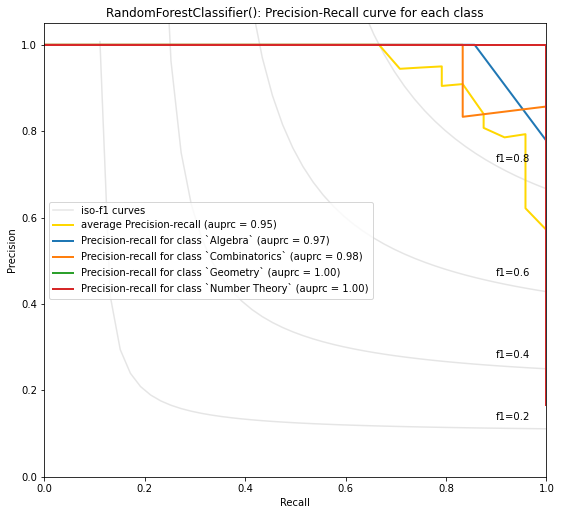

In [189]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from openai.embeddings_utils import plot_multiclass_precision_recall

X_train, X_test, y_train, y_test = train_test_split(list(questions_embedding.ada.values), questions_embedding.Topic, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)


print(report), plot_multiclass_precision_recall(probas, y_test, ['Algebra', 'Combinatorics', 'Geometry', 'Number Theory'], clf)


### Topics classification with "code-search-ada-code-001"

               precision    recall  f1-score   support

      Algebra       1.00      0.29      0.44         7
Combinatorics       0.71      0.83      0.77         6
     Geometry       0.78      1.00      0.88         7
Number Theory       0.67      1.00      0.80         4

     accuracy                           0.75        24
    macro avg       0.79      0.78      0.72        24
 weighted avg       0.81      0.75      0.71        24

RandomForestClassifier() - Average precision score over all classes: 0.80


(None, None)

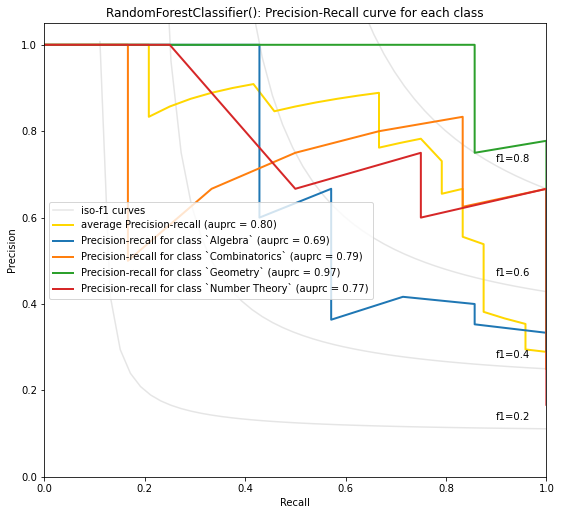

In [193]:
X_train, X_test, y_train, y_test = train_test_split(list(questions_embedding.ada_codesearch.values), questions_embedding.Topic, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)

print(report), plot_multiclass_precision_recall(probas, y_test, ['Algebra', 'Combinatorics', 'Geometry', 'Number Theory'], clf)



### Topics classification with "text-similarity-babbage-001"

               precision    recall  f1-score   support

      Algebra       1.00      0.29      0.44         7
Combinatorics       0.86      1.00      0.92         6
     Geometry       0.88      1.00      0.93         7
Number Theory       0.57      1.00      0.73         4

     accuracy                           0.79        24
    macro avg       0.83      0.82      0.76        24
 weighted avg       0.86      0.79      0.75        24

RandomForestClassifier() - Average precision score over all classes: 0.87


(None, None)

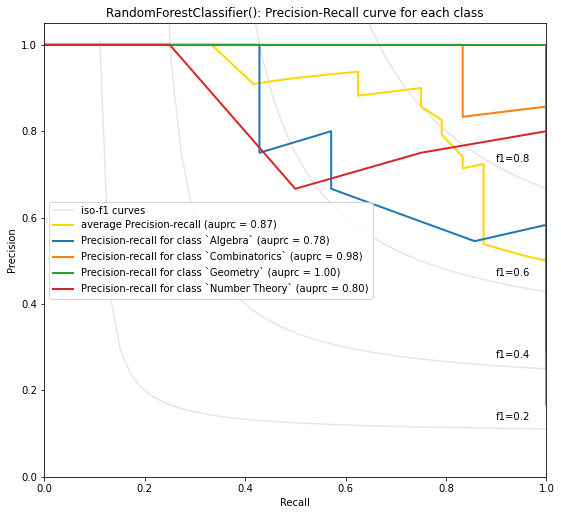

In [196]:
X_train, X_test, y_train, y_test = train_test_split(list(questions_embedding.babbage_similarity.values), questions_embedding.Topic, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)

preds = clf.predict(X_test) 
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)

print(report), plot_multiclass_precision_recall(probas, y_test, ['Algebra', 'Combinatorics', 'Geometry', 'Number Theory'], clf)

### Difficulty classification with "text-embedding-ada-002"

In [200]:
questions_embedding.Difficulty.value_counts()

Difficulty
Intermediate    40
Introductory    40
Olympiad        40
Name: count, dtype: int64

              precision    recall  f1-score   support

Intermediate       0.57      0.36      0.44        11
Introductory       0.60      0.67      0.63         9
    Olympiad       0.43      0.75      0.55         4

    accuracy                           0.54        24
   macro avg       0.53      0.59      0.54        24
weighted avg       0.56      0.54      0.53        24

RandomForestClassifier() - Average precision score over all classes: 0.43


(None, None)

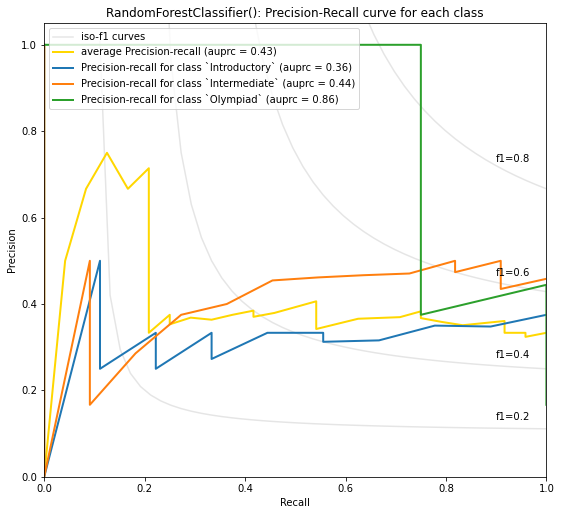

In [201]:
X_train, X_test, y_train, y_test = train_test_split(list(questions_embedding.ada.values), questions_embedding.Difficulty, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)

print(report), plot_multiclass_precision_recall(probas, y_test, ['Introductory','Intermediate','Olympiad'], clf)

### Difficulty classification with "code-search-ada-code-001"

              precision    recall  f1-score   support

Intermediate       1.00      0.36      0.53        11
Introductory       0.60      1.00      0.75         9
    Olympiad       0.80      1.00      0.89         4

    accuracy                           0.71        24
   macro avg       0.80      0.79      0.72        24
weighted avg       0.82      0.71      0.67        24

RandomForestClassifier() - Average precision score over all classes: 0.40


(None, None)

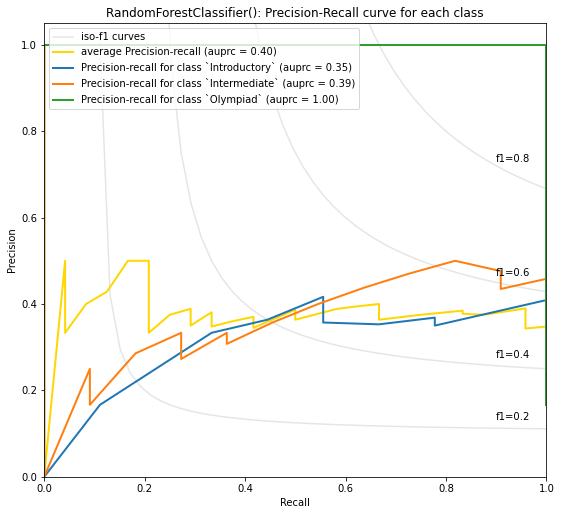

In [202]:
X_train, X_test, y_train, y_test = train_test_split(list(questions_embedding.ada_codesearch.values), questions_embedding.Difficulty, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)

print(report), plot_multiclass_precision_recall(probas, y_test, ['Introductory','Intermediate','Olympiad'], clf)

### Difficulty classification with "text-similarity-babbage-001"

              precision    recall  f1-score   support

Intermediate       1.00      0.36      0.53        11
Introductory       0.69      1.00      0.82         9
    Olympiad       0.57      1.00      0.73         4

    accuracy                           0.71        24
   macro avg       0.75      0.79      0.69        24
weighted avg       0.81      0.71      0.67        24

RandomForestClassifier() - Average precision score over all classes: 0.35


(None, None)

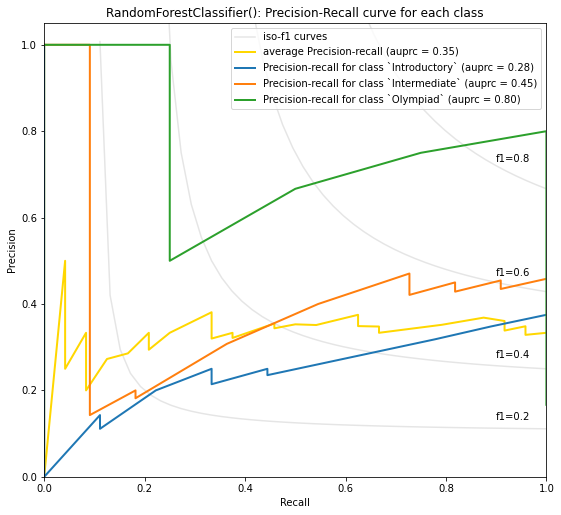

In [203]:
X_train, X_test, y_train, y_test = train_test_split(list(questions_embedding.babbage_similarity.values), questions_embedding.Difficulty, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
probas = clf.predict_proba(X_test)

report = classification_report(y_test, preds)

print(report), plot_multiclass_precision_recall(probas, y_test, ['Introductory','Intermediate','Olympiad'], clf)